In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import json

In [2]:
M=100
ite=10
block=[0,4,9]
#block=[0,1,2,3,4,5,6,7,8,9]
T=1
T_c=1
T_f=0.1
delta_c=torch.tensor(T_c/ite)
delta_f=torch.tensor(T_f/ite)
a=0.1
b=0.1
c=0.1
d=0.1
A=0.1
B=0.1
sigma=0.01
alpa=0.1
beta=0.1
neuron_model_psi=10
dim_n=2
up_lim=1
print(delta_c,delta_f)

tensor(0.1000) tensor(0.0100)


In [3]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [4]:
model_coarse = torch.load('model_N10_LQC_uniform_0_1_alpa_0.1.pth')
# model_value=torch.load('model_N10_LQC_Value_uniform_0_1.pth')

In [5]:
data=np.load('state_var_dic_N10_uniform_0_1.npz')
state_data = torch.tensor(data['state variable'])
sample=state_data[0]
# print(state_data[0,:,])

In [6]:
def update(x3,psi,z,i,delta):
    t=(x3[:,0]+(T_f/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up
    
def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

def loss_func_ter(x4,f,h,k,i):
    v_f=f[i+1]*torch.pow(x4[:,1],2)+h[i+1]*x4[:,1]+k[i+1]
    return v_f

def unit(x1,model,i,delta):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i,delta)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(model,delta,f,h,k):
    loss_total=0.0    
    for num in range(len(block)):       
        loss=torch.zeros(M,ite)
        psi=torch.zeros(M,ite)
        block_pos=block[num]
        t=torch.zeros([M,1])+block_pos*delta_c
        element=state_data[block_pos,:,1].reshape(M,1)
        u=torch.cat((t,element),dim=1)
        for i in range(ite+1):
            if(i<ite):
                psi_run,loss_run,u_run=unit(u,model,i,delta)
                #print('los func=',psi_run.shape,loss_run.shape)
                loss[:,i]=loss_run
                #print(loss)
                psi[:,i]=psi_run
                #print(psi)
                u=u_run
              #print(u)
            else:
                loss_ter=loss_func_ter(u,f,h,k,block_pos)
#                 loss_ter=model_value(u).squeeze(1).clone().detach()
              #print('ter',loss_ter.shape)
            #print(torch.sum(loss,dim=1))
        loss=torch.sum(loss,dim=1)*delta+loss_ter
        loss_total=loss_total+loss
    return torch.mean(loss_total)

In [7]:
# t=torch.zeros([M,1])
# #x=torch.FloatTensor(M,1).uniform_(0.0,up_lim)
# element=state_data[block,:,1].reshape(1000,1)
z=torch.FloatTensor(M,ite+1).uniform_(0,0.01)
# x=torch.cat((t,element),dim=1)
# print('coarse soution=',c_soln[0])
# print(x.shape)

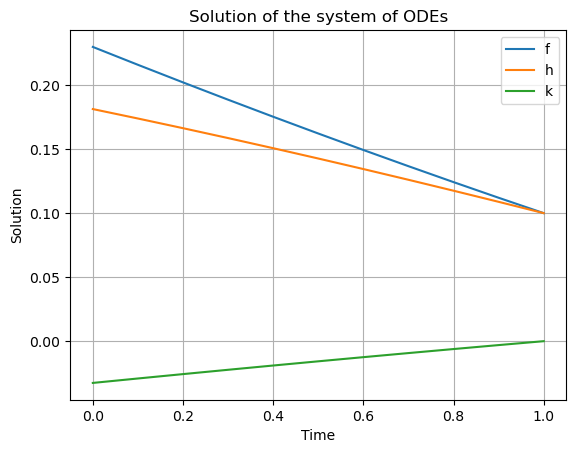

In [8]:
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time

# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, ite+1))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f') 
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [9]:
start=time.time()
lr1 = 8e-3
max_epoch = 2000
cost_ar=[]
optimizer = optim.Adam(model_f.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(model_f,delta_f,f,h,k)
  cost.backward()
  optimizer.step()
  cost_ar.append(cost)
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
total_time=end-start
print('time elapsed=',total_time)

At epoch 0 the mean cost is 0.34373268485069275.
At epoch 100 the mean cost is 0.33165523409843445.
At epoch 200 the mean cost is 0.33164337277412415.
At epoch 300 the mean cost is 0.3316423296928406.
At epoch 400 the mean cost is 0.33164212107658386.
At epoch 500 the mean cost is 0.3316419720649719.
At epoch 600 the mean cost is 0.33164170384407043.
At epoch 700 the mean cost is 0.33164164423942566.
At epoch 800 the mean cost is 0.33164161443710327.
At epoch 900 the mean cost is 0.3316415846347809.
At epoch 1000 the mean cost is 0.3316415548324585.
At epoch 1100 the mean cost is 0.3316414952278137.
At epoch 1200 the mean cost is 0.33164146542549133.
At epoch 1300 the mean cost is 0.33164143562316895.
At epoch 1400 the mean cost is 0.3316413462162018.
At epoch 1500 the mean cost is 0.331641286611557.
At epoch 1600 the mean cost is 0.33164119720458984.
At epoch 1700 the mean cost is 0.3316410779953003.
At epoch 1800 the mean cost is 0.33164092898368835.
At epoch 1900 the mean cost is 0.

In [10]:
M2=10
x_ar=[]
z1=torch.FloatTensor(M2,ite).uniform_(0,0.01)
t_test=torch.zeros([M2,1])
x1=torch.linspace(0.1*up_lim,0.95*up_lim, steps=M2).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
#pred_soln=torch.zeros(M2,ite)
pred_soln=[]
for i in range(ite):
    for j in range(ite):        
        x_ar.append(x_test[:,1].numpy())
        soln_pred=model_f.eval()(x_test).squeeze(1).detach()
        #print(soln_pred)
        #pred_soln[:,i]=soln_pred
        pred_soln.append(soln_pred.numpy())
        x_test=update(x_test,soln_pred,z1,j,delta_f)
#         if(torch.floor(x_test[0,0]*10)!=0):
#             x_test[:,0]=0.0
#         print(x_test)
x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
pred=np.squeeze(np.array(pred_soln))
pred=pred.transpose()
print(pred.shape,state_var.shape)
# print(pred[0],state_var[0])

(10, 100) (10, 101)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


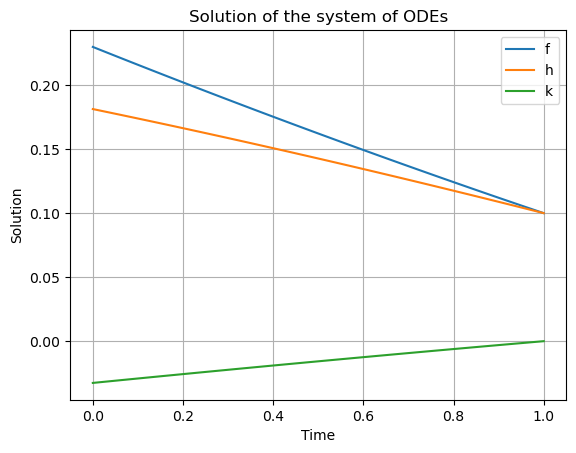

In [11]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(d**2*y[0]**2)/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        sigma**2*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T_c)  # Start and end time
t_eval=np.linspace(0, T_c, ite*ite+1)
print(t_eval)
# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T_c, ite*ite+1))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
plt.show()

In [12]:
def optimal_soln_numerical(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def value_func_numerical(x,f,h,k):
    V=f*x**2+h*x+k
    return V

def optimal_soln_closed(x,t):
    q0=1
    q1=2*c
    q2=-d**2/A
    S=q0*q2
    R=q1
    L1=(R+np.sqrt(R**2-4*S))/2
    L2=(R-np.sqrt(R**2-4*S))/2
    
    top = (-q2*alpa*np.cosh(L1*t)+L2*np.sinh(L2*t))
    bottom = ((-q2*alpa/L1)*np.sinh(L1*t)+np.cosh(L2*t))
    
    f = (A/d**2)*top/bottom
    h = ((-q2*alpa*b/L1**2)*np.cosh(L1*t)+b*np.sinh(L2*t)/L2)/bottom - B/d +(beta+B/d+q2*alpa*b/L1**2)/bottom
#     k = sigma**2*np.log(bottom)   
    u = -(B+d*(2*x*f+h))/(2*A)
    
    return u

def total_cost(x,u,ite):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*x[i]**2+b*x[i]+A*u[i]**2+B*u[i]
        else:
            cost_ter=alpa*x[i]**2+beta*x[i]
    cost_total=cost_run*delta_f.numpy()+cost_ter 
    return cost_total

In [13]:
# print(state_var.shape)
# t_eval=np.linspace(0,T,ite*ite)
# u=np.zeros([M2,ite*ite])
# for i in range(M2):
#     #print('state variable',state_var[i])
#     u[i]=optimal_soln(state_var[i],f,h)
#     print('\n True solution',u[i])
#     true_cost=total_cost(state_var[i],u[i])
#     print('\n True cost=',true_cost)
#     print('\n Predicted solution',pred[i])
#     pred_cost=total_cost(state_var[i],pred[i])
#     print('\n Predicted cost=',pred_cost)
#     print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

In [14]:
u=np.zeros([M2,ite*ite+1])
u1=np.zeros([M2,ite*ite+1])
V=np.zeros([M2,ite*ite+1])
t_eval=np.linspace(0, T_c, ite*ite+1)
pred_cost=np.zeros(M2)
numeric_cost=np.zeros(M2)
error_percnt=np.zeros(M2)
# pred=pred_soln.numpy()
# print(state_var[0,:].shape,u[0,:].shape,ite)
print(pred[0,:].shape,u[0,:].shape)
for i in range(M2):
    #print('state variable',state_var[i].shape,u[i,:].shape,optimal_soln(state_var[i],f,h).shape,pred[i,:].shape)
#     u[i,:]=optimal_soln_closed(state_var[i,:],t_eval)
    u1[i,:]=optimal_soln_numerical(state_var[i,:],f,h)
    print('\n Numerical solution',u1[i,:])
    numeric_cost[i]=total_cost(state_var[i,:],u1[i,:],ite)
    print('\n Numerical cost=',numeric_cost[i])
    print('\n Predicted solution',pred[i])
    pred_cost[i]=total_cost(state_var[i,:],pred[i],ite)
    print('\n Predicted cost=',pred_cost[i])
    error_percnt[i]= np.abs(100*(np.abs(numeric_cost[i])-np.abs(pred_cost[i]))/numeric_cost[i])
    print('Percent Error wrt Numeric Cost=',error_percnt[i],'%\n')
    

(100,) (101,)

 Numerical solution [-0.61362501 -0.61299841 -0.6123726  -0.61174741 -0.61112432 -0.61050257
 -0.60988067 -0.60926029 -0.60864003 -0.60802082 -0.60740287 -0.60678588
 -0.60616964 -0.60555401 -0.60494035 -0.60432797 -0.60371546 -0.60310439
 -0.60249345 -0.60188351 -0.60127476 -0.60066692 -0.60005981 -0.59945327
 -0.5988486  -0.59824513 -0.59764156 -0.59703935 -0.59643728 -0.59583615
 -0.59523616 -0.59463702 -0.59403859 -0.5934407  -0.59284457 -0.59224957
 -0.5916545  -0.59106071 -0.59046706 -0.58987431 -0.58928262 -0.58869175
 -0.58810155 -0.58751187 -0.58692384 -0.58633688 -0.58574986 -0.58516405
 -0.58457839 -0.58399358 -0.58340977 -0.58282673 -0.58224433 -0.58166243
 -0.58108207 -0.58050271 -0.57992333 -0.57934507 -0.57876696 -0.57818966
 -0.5776133  -0.57703767 -0.57646264 -0.57588809 -0.57531498 -0.57474281
 -0.57417063 -0.5735995  -0.57302854 -0.57245831 -0.57188866 -0.5713194
 -0.57075042 -0.57018163 -0.56961389 -0.56904677 -0.56847941 -0.56791278
 -0.56734608 -0.5

In [15]:
# data = np.column_stack((state_var[:,0],pred_cost, numeric_cost,error_percnt))
# np.savetxt('LQC_Multiscal_Closed_N100_Cost.txt', data, header=' X0 (Initial Value)         Predicted Cost          Numerical cost          Percent Error', comments='')

(10, 100)
(100,)


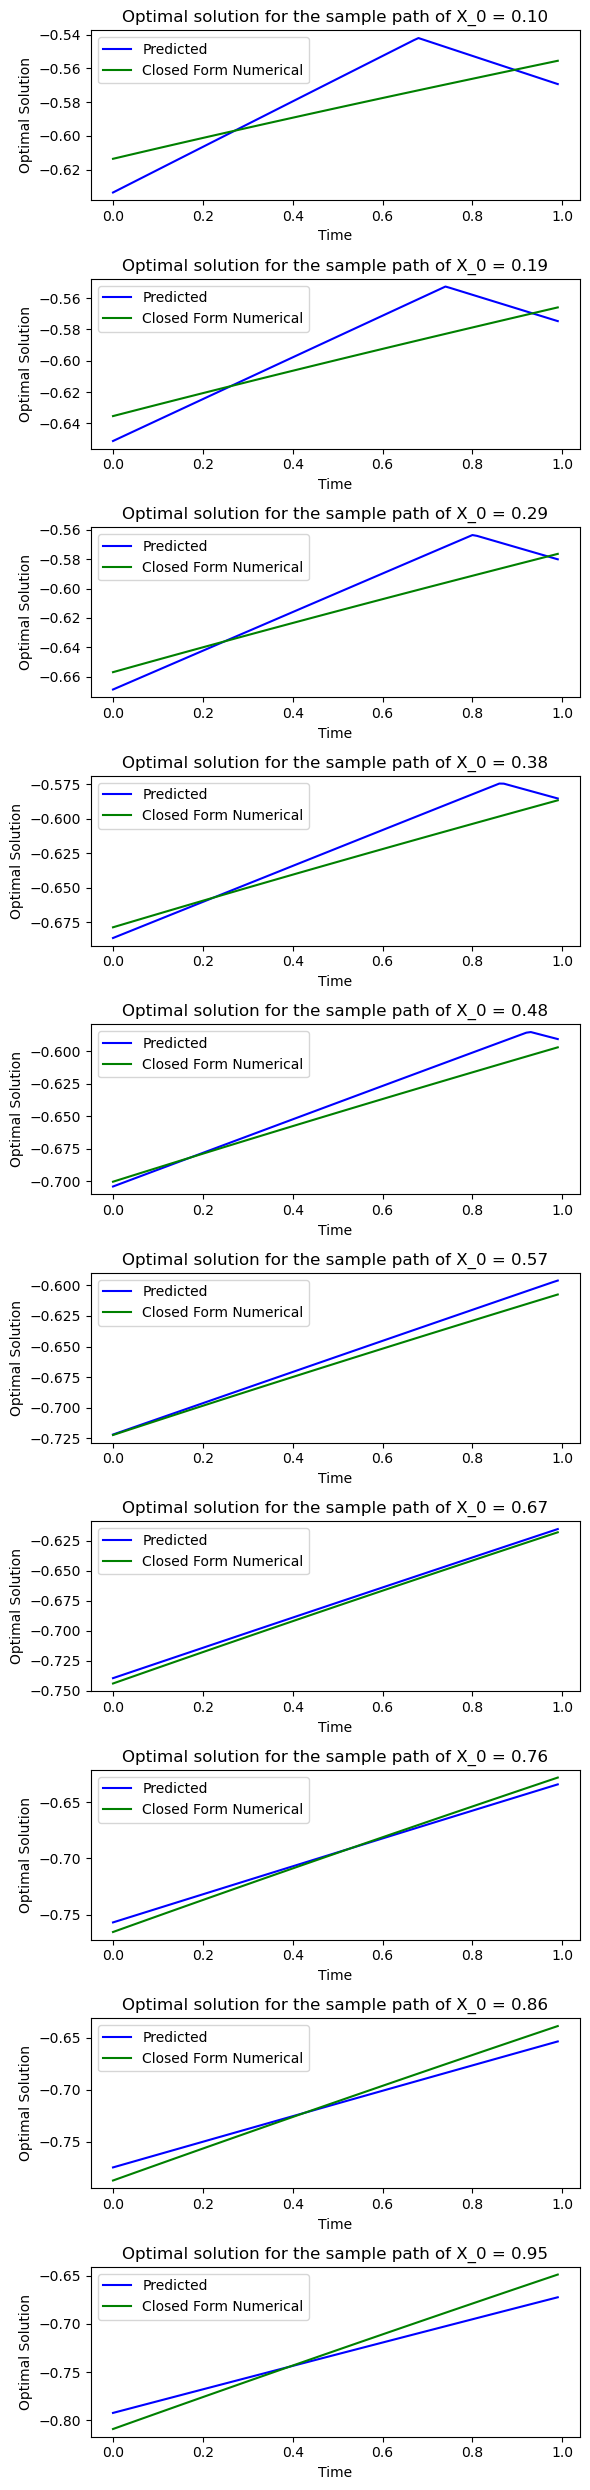

In [16]:
u_del=np.delete(u, -1, axis=1) # Just dropping the last time step as there is no control in final time
print(u_del.shape)
u1_del=np.delete(u1, -1, axis=1)
fig, axs = plt.subplots(M2,1, figsize=(6, 25))
t_eval=np.linspace(0,0.99,ite*ite)
print(t_eval.shape)
# Plot x vs y and x vs z on each subplot
for i, ax in enumerate(axs):
    ax.plot(t_eval,pred[i,:], color='b', label='Predicted')
#     ax.plot(t_eval,u_del[i,:], color='r', label='Closed Form Continuous')
    ax.plot(t_eval, u1_del[i,:], color='g', label='Closed Form Numerical')
    ax.set_xlabel('Time')
    ax.set_ylabel('Optimal Solution')
    ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [17]:

import matplotlib
# Set the backend for Qt5Agg
matplotlib.use('Qt5Agg')

x_0_values = state_var[:, 0]  # Assuming state_var[:, 0] holds your x_0 values for each i

# Increase the figure size
plt.figure(figsize=(8,6))

# Loop to plot each graph
for i in range(1, M2, 2):
    plt.plot(t_eval, pred[i, :], color='b', label='Predicted' if i == 0 else "")  # Show label only once
    plt.plot(t_eval, u1_del[i, :], color='r', label='Closed Form' if i == 0 else "") # Show label only once
    
    # Add x_0 value near each line
    plt.text(t_eval[-1], pred[i, -1], f'X_0= {x_0_values[i]:.2f}', color='black', fontsize=10, 
             ha='right', va='bottom')  # Label for predicted solution
#     plt.text(t_eval[-1], u_del[i, -1], f'x_0 = {x_0_values[i]:.2f}', color='red', fontsize=10, 
#              ha='left', va='center')  # Label for true solution
    
    plt.xlabel('Time')
    plt.ylabel('Optimal Solution')
    plt.title('Optimal solution for different sample paths starting with X_0')

    # Display legend only once
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [18]:
# torch.save(model_f, 'model_f_N10_LQC_uniform_0_1.pth')

# # state_var_train=np.squeeze(np.array(state_var_train))

# # state_var_dic = {'state variable':state_var_train}

# # np.savez('state_var_dic_multi_N10_uniform_0_1.npz',**state_var_dic)

# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N10_fine_dic_uniform_0_1.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)


In [19]:
# t_eval=np.linspace(0,T_c,100)
# u=optimal_soln(state_var,f,h)
# V=value_func(state_var,f,h,k)

# print('state variable',state_var)
# print('\n True solution',u)
# true_cost=total_cost(state_var,u)
# print('\n True cost=',true_cost)
# print('\n Predicted solution',pred)
# pred_cost=total_cost(state_var,pred)
# print('\n Predicted cost=',pred_cost)
# print('Absolute Error',np.abs(u)-np.abs(pred))
# print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

In [20]:
# plt.figure(figsize=(14,6))
# plt.plot(t_eval,pred, color='b', label='Pred Soln')
# plt.plot(t_eval,u, color='r', label='True soln')
# plt.xlabel('Time steps')
# plt.ylabel('Optimal Solution')
# plt.title(f'Optimal solution for the sample path of X_0 = {state_var[0]:.2f}')
# plt.legend()
# plt.show()